### Importing SQL movie database

In [1]:
from src.make_db import create_movies_db

In [2]:
create_movies_db()

imdb_title_principals table created successfully....
imdb_name_basic table created successfully....
imdb_title_crew table created successfully....
imdb_title_ratings table created successfully....
imdb_title_basics table created successfully....
imdb_title_akas table created successfully....
tn_movie_budgets table created successfully....
tmdb_movies table created successfully....
bom_movie_gross table created successfully....
rotten_tomatoes_critic_reviews table created successfully....
rotten_tomatoes_movies table created successfully....
Inserting data into the imdb_title_crew table....
Inserting data into the tmdb_movies table....
Inserting data into the imdb_title_akas table....
Inserting data into the imdb_title_ratings table....
Inserting data into the imdb_name_basics table....
Inserting data into the rotten_tomatoes_movies table....
Inserting data into the rotten_tomatoes_critic_reviews table....
Inserting data into the imdb_title_basics table....
Inserting data into the tn_mo

In [3]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("data/movies.db")
# Gotta import the proper tools for the job!

### Cleaning Movie budgets

First I looked at the movie budget table to formulate a plan of attack.

In [4]:
pd.read_sql("""
SELECT *
FROM tn_movie_budgets
""", conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   idx                5782 non-null   int64 
 1   id                 5782 non-null   int64 
 2   release_date       5782 non-null   object
 3   movie              5782 non-null   object
 4   production_budget  5782 non-null   object
 5   domestic_gross     5782 non-null   object
 6   worldwide_gross    5782 non-null   object
dtypes: int64(2), object(5)
memory usage: 316.3+ KB


In [5]:
df_tmb = pd.read_sql("""
SELECT *
FROM tn_movie_budgets
""", conn)

After creating a pandas data frame I cleaned the numerical values to prepare them to interact with each other.

In [6]:
df_tmb["production_budget"] = df_tmb["production_budget"].apply(lambda x: int(x.replace("$", "").replace(",", "")))
df_tmb["domestic_gross"] = df_tmb["domestic_gross"].apply(lambda x: int(x.replace("$", "").replace(",", "")))
df_tmb["worldwide_gross"] = df_tmb["worldwide_gross"].apply(lambda x: int(x.replace("$", "").replace(",", "")))

I created an overall profit column as that is the best way to measure movie success.

In [7]:
df_tmb["worldwide_profit"] = df_tmb["worldwide_gross"] - df_tmb["production_budget"]

The below cells cleaned up the table by dropping unnecessary columns and illimating rows that likely contained poor data.

In [8]:
df_tmb = df_tmb[df_tmb["domestic_gross"] >= 1]
df_tmb = df_tmb[df_tmb["worldwide_gross"] >= 1]
# It's highly unlikely a movie is produced that literally no one goes to see. 
# Therefore if the gross value is 0 it can be considered innaccurate data.

In [9]:
df_tmb = df_tmb.drop(columns = ["id", "domestic_gross"])
# we don't need domestic gross if what is important is overall profit, id would also go unused in our analysis

In [10]:
df_tmb = df_tmb.set_index("idx")
# This column was the same as the index already so it just saved space to replace the index with it

In [11]:
df_tmb["title"] = df_tmb["movie"]
# I renamed column to prepare for a dataframe merge in the future.

In [12]:
df_tmb = df_tmb.drop(columns = ["movie"])
# We don't need a title and movie column that say the same things

In [13]:
df_tmb = df_tmb.sort_values("worldwide_gross", ascending = False).drop_duplicates(subset = ["title"])
# drop the dumb duplicates

In [14]:
df_tmb
# Reviewing final product

,release_date,production_budget,worldwide_gross,worldwide_profit,title
idx,,,,,
0,"Dec 18, 2009",425000000,2776345279,2351345279,Avatar
42,"Dec 19, 1997",200000000,2208208395,2008208395,Titanic
5,"Dec 18, 2015",306000000,2053311220,1747311220,Star Wars Ep. VII: The Force Awakens
6,"Apr 27, 2018",300000000,2048134200,1748134200,Avengers: Infinity War
33,"Jun 12, 2015",215000000,1648854864,1433854864,Jurassic World
...,...,...,...,...,...
5027,"Jan 1, 1993",1800000,673,-1799327,Ed and his Dead Mother
5466,"May 11, 2018",500000,528,-499472,Higher Power
5769,"Apr 1, 1996",10000,527,-9473,Bang


### Cleaning title basics

The steps for each cleaning section are fairly rinse and repeat as above. Examine the inital table, determine if I need to add or remove columns, and get rid of null values in rows either by removing the rows or replacing the values.

In [15]:
pd.read_sql("""
SELECT *
FROM imdb_title_basics
""", conn).info()
# Examining the table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   idx              146144 non-null  int64  
 1   tconst           146144 non-null  object 
 2   primary_title    146144 non-null  object 
 3   original_title   146123 non-null  object 
 4   start_year       146144 non-null  int64  
 5   runtime_minutes  114405 non-null  float64
 6   genres           140736 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 7.8+ MB


In [16]:
df_itb = pd.read_sql("""
SELECT *
FROM imdb_title_basics
""", conn)

Dropping columns and setting the index columns up to make the table cleaner to work with

In [17]:
df_itb = df_itb.drop(columns = ["original_title", "tconst"])
# As we already have primary title we have no need for the original title, tconst also just has no meaningful value for our analysis.

In [18]:
df_itb = df_itb.set_index("idx")
# Once again the idx was identical to the index so it just made sense to make them completely the same

In [19]:
df_itb = df_itb.drop_duplicates(subset = ["primary_title"])

In [20]:
df_itb = df_itb.drop_duplicates()
# There were a large amount of duplicate movies that just had unique tconst or idx values.
# As they have been dealt with we can no successfully run drop_duplicates()

In [21]:
df_itb["title"] = df_itb["primary_title"]
# Renaming column to title to prepare for later merge

In [22]:
df_itb = df_itb.drop(columns = ["primary_title"])
# We don't need two title columns

In [23]:
df_itb["genres"] = df_itb["genres"].apply(lambda x: x.split(",") if type(x) == str else x)
df_itb
# splitting up each genre section into a list of genres and making a quick sanity check

,start_year,runtime_minutes,genres,title
idx,,,,
0,2013,175.0,"[Action, Crime, Drama]",Sunghursh
1,2019,114.0,"[Biography, Drama]",One Day Before the Rainy Season
2,2018,122.0,[Drama],The Other Side of the Wind
3,2018,NaN,"[Comedy, Drama]",Sabse Bada Sukh
4,2017,80.0,"[Comedy, Drama, Fantasy]",The Wandering Soap Opera
...,...,...,...,...
146139,2019,123.0,[Drama],Kuambil Lagi Hatiku
146140,2015,NaN,[Documentary],Rodolpho Teóphilo - O Legado de um Pioneiro
146141,2013,NaN,[Comedy],Dankyavar Danka


In [24]:
df_itb.isna().sum()
# determining if the amount of missing genres is too many for me to drop the rows.
# As only 3.7 percent of the rows would be dropped I determined them safe to remove.
# My rule of thumb is maintaining a loss rate of less than 20 percent

start_year             0
runtime_minutes    29473
genres              4891
title                  0
dtype: int64

In [25]:
df_itb = df_itb.dropna(subset = ["genres"])
# dropping all the rows where the genre is nonexistent

In [26]:
df_itb = df_itb.explode("genres")
# This splits the dataframe into multiple different rows such that each row only contains one genre.
# i.e. If a movie had three genres it would now have three seperate unique rows with one genre each in the final dataframe.

In [27]:
df_itb["genre"] = df_itb["genres"]
# renaming genres to make it more accurate now that it is one genre per row

In [28]:
df_itb = df_itb.drop(columns = ["genres"])
# No need for two genre columns to exist

In [29]:
df_itb.isna().sum()
# Sanity Check to insure that I dropped all null values in genres

start_year             0
runtime_minutes    33352
title                  0
genre                  0
dtype: int64

In [30]:
df_itb
# sanity check to overview the finished product

,start_year,runtime_minutes,title,genre
idx,,,,
0,2013,175.0,Sunghursh,Action
0,2013,175.0,Sunghursh,Crime
0,2013,175.0,Sunghursh,Drama
1,2019,114.0,One Day Before the Rainy Season,Biography
1,2019,114.0,One Day Before the Rainy Season,Drama
...,...,...,...,...
146138,2019,NaN,The Secret of China,War
146139,2019,123.0,Kuambil Lagi Hatiku,Drama
146140,2015,NaN,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary


### Cleaning tmbd movies

One more dataframe to go!

In [31]:
df_tmbd = pd.read_sql("""
SELECT *
FROM tmdb_movies
""", conn)

In [32]:
df_tmbd.head()
# Checking out the dataframe to make a plan of attack

,idx,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [33]:
df_tmbd = df_tmbd.drop(columns = ["genre_ids", "id", "original_language", "original_title"])
# genre ids, id, and original language would not be used in our assessment and we already have a final title so original title is not needed

In [34]:
df_tmbd = df_tmbd.set_index("idx")
# idx is identical to the index so why not make it the index

In [35]:
df_tmbd["vote_total"] = df_tmbd["vote_average"]*df_tmbd["vote_count"]
# creating a new column to calculate total vote count based off of the average vote score and the total voters

In [79]:
df_tmdb = df_tmbd.sort_values("vote_average", ascending = False).drop_duplicates(subset = ["title"])
# sanity check to overview final product

### Combine the above three dataframes

Now that we have the three main dataframes all nice and tidied up we can bring them all together. I wasn't sure if merging them all at once would work so I split it up into two different steps

In [80]:
df_intermediate = df_tmbd.merge(df_itb, on = "title")

In [81]:
df_intermediate.isna().sum()
#Note that as the tables inner merge we lose a significant number of empty runtimes.
#This is because the movie databases did not contain perfectly overlapping movies.

popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
vote_total           0
start_year           0
runtime_minutes    753
genre                0
dtype: int64

In [82]:
df_main = df_intermediate.merge(df_tmb, on = "title")
#This second merge cut down our final missing runtimes to about 450 missing values

### Cleaning Main dataframe

Once again on the path to clean data! We need to inspect the dataframes elements, remove erroneous columns, create new columns, and just overall insure the data is in a format we can use for visualizations.

In [83]:
df_main.info()
# examining contents of comprehensive dataframe to see if it makes sense/if the merge occured as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 0 to 4598
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity         4599 non-null   float64
 1   release_date_x     4599 non-null   object 
 2   title              4599 non-null   object 
 3   vote_average       4599 non-null   float64
 4   vote_count         4599 non-null   int64  
 5   vote_total         4599 non-null   float64
 6   start_year         4599 non-null   int64  
 7   runtime_minutes    4537 non-null   float64
 8   genre              4599 non-null   object 
 9   release_date_y     4599 non-null   object 
 10  production_budget  4599 non-null   int64  
 11  worldwide_gross    4599 non-null   int64  
 12  worldwide_profit   4599 non-null   int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 503.0+ KB


In [84]:
df_main = df_main.drop(columns = ["release_date_y", "start_year"])
# We don't need multiple release dates, this is redundant information. I elected to drop the date that was in partial string form

In [85]:
df_main.isna().sum()
# checking to determine if I can drop the rows of missing runtime values or if I need to replace them

popularity            0
release_date_x        0
title                 0
vote_average          0
vote_count            0
vote_total            0
runtime_minutes      62
genre                 0
production_budget     0
worldwide_gross       0
worldwide_profit      0
dtype: int64

In [86]:
df_main = df_main.dropna(subset = ["runtime_minutes"])
# as this was less than 5 percent of the total data I clearly decided to drop it

In [87]:
df_main["release_date"] = df_main["release_date_x"]
# renaming to look nice at the end

In [88]:
df_main = df_main.drop(columns = ["release_date_x"])
# deleting extra column created as a result of renaming

In [89]:
df_main["percent_returns"] = df_main["worldwide_gross"]/df_main["production_budget"]*100
# Creating a percent returns column calculated by worldwide gross divided by production budget multiplied by 100

In [90]:
df_main
# sanity check to insure I'm still on the right track

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns
0,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813
1,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Adventure,165000000,494870992,329870992,2010-03-26,299.921813
2,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Animation,165000000,494870992,329870992,2010-03-26,299.921813
3,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111
4,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Adventure,170000000,621156389,451156389,2010-05-07,365.386111
...,...,...,...,...,...,...,...,...,...,...,...,...
4594,0.600,The Box,10.0,1,10.0,89.0,Drama,25000000,34356760,9356760,2018-05-21,137.427040
4595,0.600,The Box,8.0,1,8.0,89.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040
4596,0.600,The Box,6.0,1,6.0,89.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040
4597,0.719,Enough,8.7,3,26.1,96.0,Drama,38000000,50970660,12970660,2018-03-22,134.133316


### Creating Visualizations

In [91]:
df_mainmean = df_main.groupby("genre").mean().sort_values("worldwide_profit", ascending = False)
# I initially considered creating barplots and also wanted more data to examine so I created a table based on genre
# which showed the mean values of all the integer/float columns.

In [92]:
df_mainmean = df_mainmean.reset_index()
# I was struggling to have genre on a graph so I had to pull it from the index into its own column

In [93]:
df_mainmean
# looking at the table of mean values to formulate a visualization plan

,genre,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
0,Animation,15.311292,6.554717,2785.566038,19298.707547,95.169811,9.959434e+07,3.774225e+08,2.778281e+08,383.583839
1,Adventure,17.680828,6.374536,3976.984085,27198.927851,111.339523,1.052349e+08,3.592523e+08,2.540174e+08,334.731109
2,Sci-Fi,17.331122,6.331410,4589.583333,32000.405769,113.596154,8.645247e+07,3.223228e+08,2.358703e+08,367.619218
3,Action,16.688753,6.187773,3410.635371,22976.101528,112.849345,8.257904e+07,2.615523e+08,1.789733e+08,322.571959
4,Fantasy,15.602755,6.130216,3082.676259,20112.976978,110.410072,8.232482e+07,2.582219e+08,1.758970e+08,339.335712
5,Musical,10.608100,6.160000,1706.500000,12765.050000,115.600000,5.126000e+07,2.032923e+08,1.520323e+08,250.854039
6,Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206
7,Comedy,11.379656,6.270415,1633.726644,10978.081315,101.719723,3.883083e+07,1.331579e+08,9.432706e+07,376.500128
8,Sport,7.775196,6.358696,925.043478,6511.928261,105.847826,2.530000e+07,1.096872e+08,8.438722e+07,644.462607
9,Thriller,11.254702,5.893168,1734.204969,11550.141925,104.605590,3.275625e+07,1.122991e+08,7.954280e+07,688.126177


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# can't forget to import the libraries you'll need to use

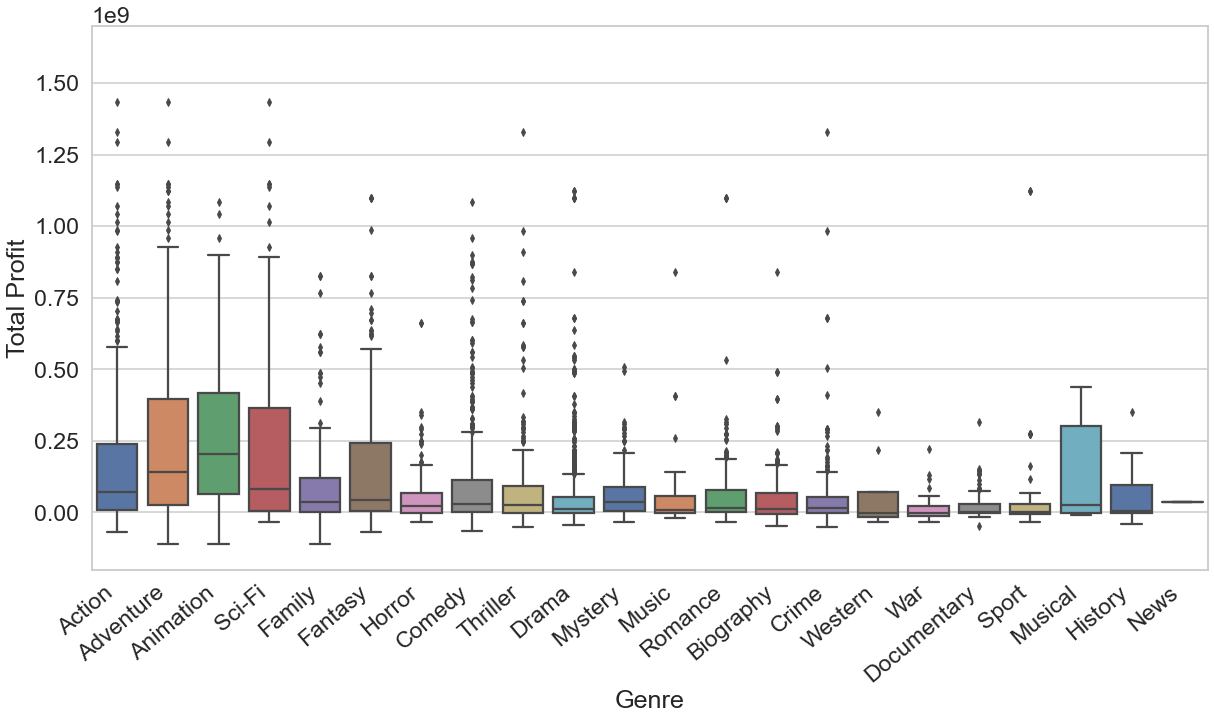

In [95]:
fig, ax = plt.subplots(figsize = (20,10))
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.4)

sns.boxplot(data = df_main, x = "genre", y = "worldwide_profit", palette = "deep").set(ylim = (-200000000, 1700000000), ylabel = "Total Profit", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");
# creating a broad boxplot looking at individual genres and total profit using seaborn. 



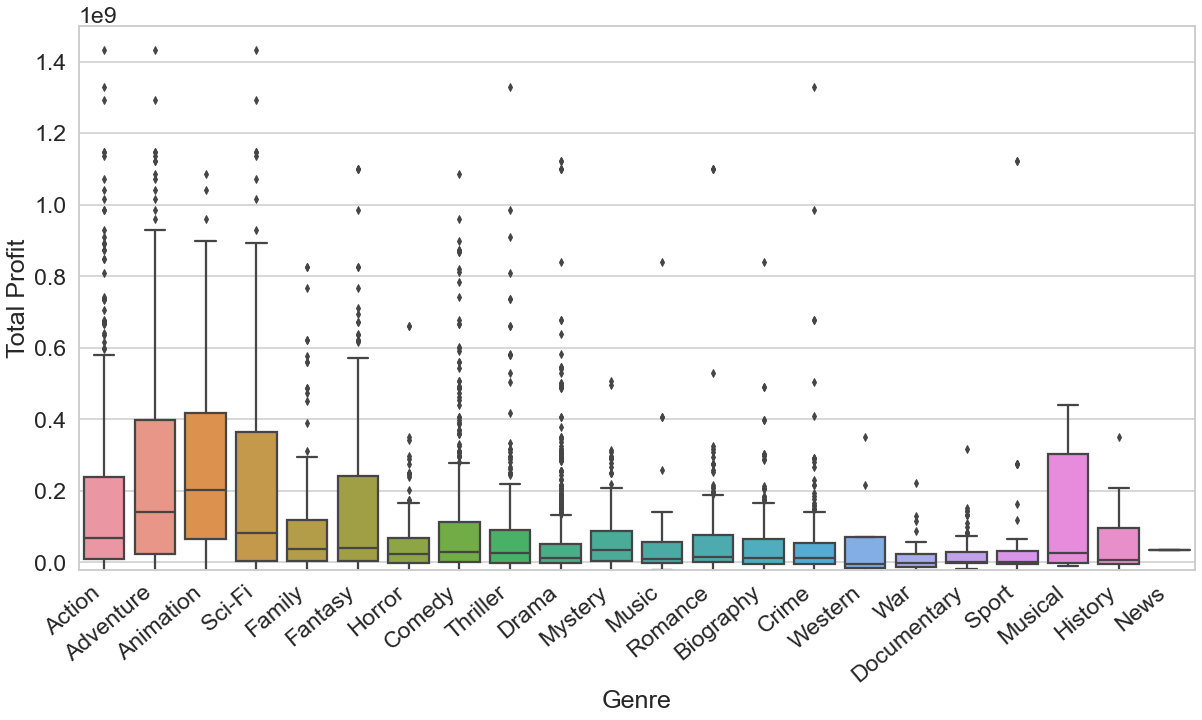

In [96]:
fig, ax = plt.subplots(figsize = (20,10))


sns.boxplot(data = df_main, x = "genre", y = "worldwide_profit").set(ylim = (-20000000, 1500000000), ylabel = "Total Profit", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# playing with the y axis limit to find what looks best for the chart 

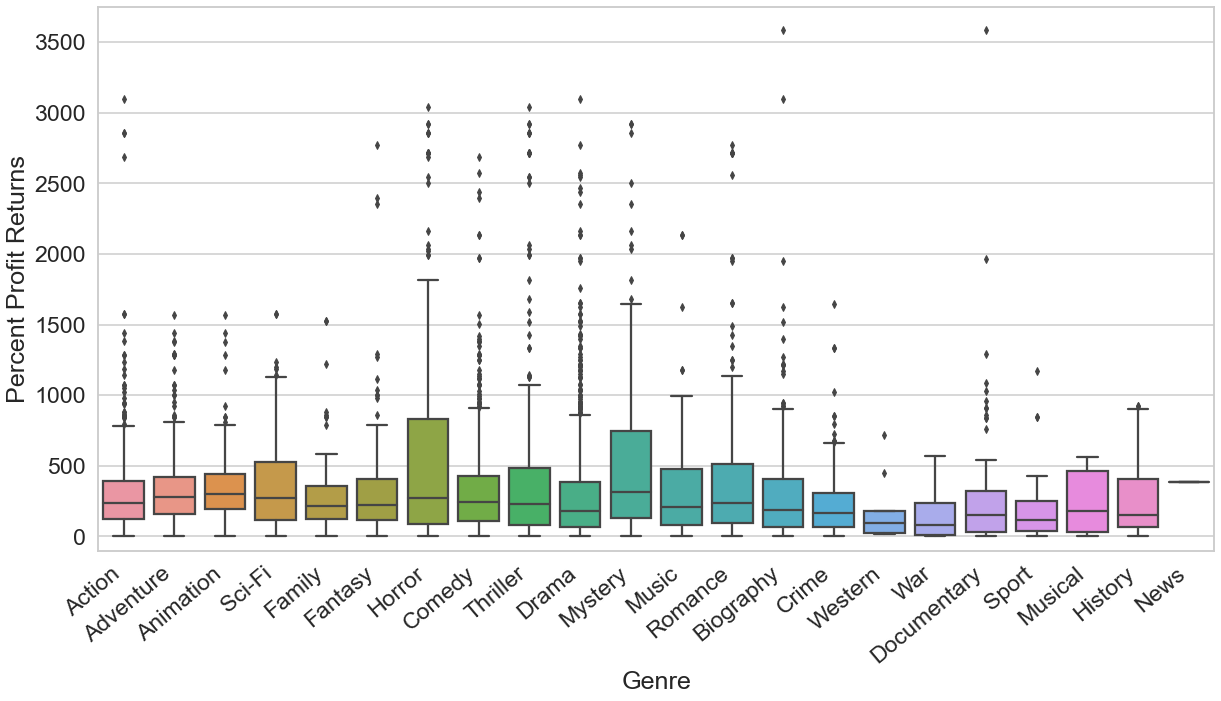

In [97]:
fig, ax = plt.subplots(figsize = (20,10))


sns.boxplot(data = df_main, x = "genre", y = "percent_returns").set(ylim = (-100, 3750), ylabel = "Percent Profit Returns", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# creating a boxplot that examines the percent profit return by movie genre

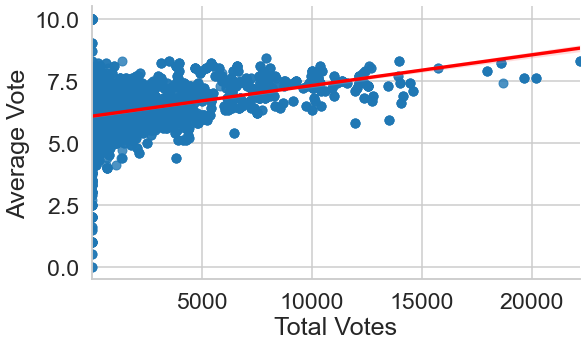

In [98]:
sns.lmplot(aspect=15/9, data = df_main, x = "vote_count", y = "vote_average", line_kws={'color': 'red'}).set(ylabel = "Average Vote", xlabel = "Total Votes");
# Here is a linear regression model comparing how the overall vote count impacts the average score of a movie.
# It effectively just confirms a positivity bias

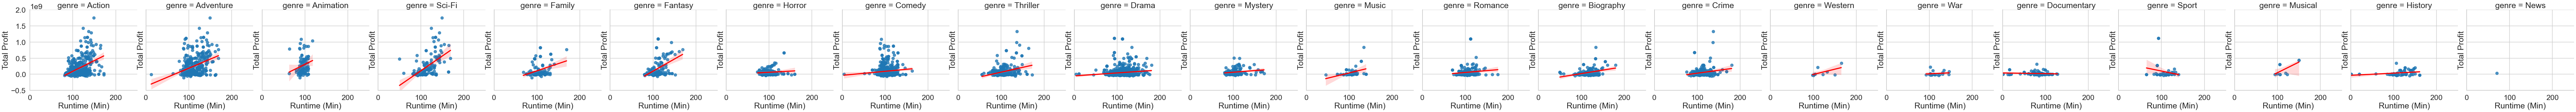

In [99]:
runtime = sns.lmplot(data = df_main, x = "runtime_minutes", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-500000000, 2000000000), xlim = (0, 250), ylabel = "Total Profit", xlabel = "Runtime (Min)");
# These graphs were created as linear regression models of overall profit in relation to the length of the movie.
# Each individiual genre has its own linear regression model created for it.

## Making top 7 dataframes

In [100]:
df_mainmean.sort_values("percent_returns", ascending = False).head(7)
# We determined that as we are attempting to give suggestions for a successful movie not an unsuccessful one,
# we should only look at the top seven movies in both percent returns and worldwide profit categories

,genre,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
13,Horror,10.013285,5.695928,1391.778281,8827.803167,98.583710,2.053599e+07,8.207340e+07,6.153741e+07,1088.129799
10,Mystery,12.474294,6.136364,2163.104895,14810.875524,106.468531,2.699386e+07,9.733352e+07,7.033965e+07,1023.680200
9,Thriller,11.254702,5.893168,1734.204969,11550.141925,104.605590,3.275625e+07,1.122991e+08,7.954280e+07,688.126177
8,Sport,7.775196,6.358696,925.043478,6511.928261,105.847826,2.530000e+07,1.096872e+08,8.438722e+07,644.462607
11,Romance,9.536311,6.456596,1376.519149,9378.966383,104.770213,2.303709e+07,8.547409e+07,6.243700e+07,507.634802
6,Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206
19,News,4.738000,5.400000,21.000000,113.400000,70.000000,1.200000e+07,4.673058e+07,3.473058e+07,389.421483


In [101]:
df_mainmean.sort_values("worldwide_profit", ascending = False).head(7)

,genre,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
0,Animation,15.311292,6.554717,2785.566038,19298.707547,95.169811,9.959434e+07,3.774225e+08,2.778281e+08,383.583839
1,Adventure,17.680828,6.374536,3976.984085,27198.927851,111.339523,1.052349e+08,3.592523e+08,2.540174e+08,334.731109
2,Sci-Fi,17.331122,6.331410,4589.583333,32000.405769,113.596154,8.645247e+07,3.223228e+08,2.358703e+08,367.619218
3,Action,16.688753,6.187773,3410.635371,22976.101528,112.849345,8.257904e+07,2.615523e+08,1.789733e+08,322.571959
4,Fantasy,15.602755,6.130216,3082.676259,20112.976978,110.410072,8.232482e+07,2.582219e+08,1.758970e+08,339.335712
5,Musical,10.608100,6.160000,1706.500000,12765.050000,115.600000,5.126000e+07,2.032923e+08,1.520323e+08,250.854039
6,Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206


In [102]:
df_main.head()
# A quick sanity check to clear my head and refocus on what needed to be done

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns
0,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813
1,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Adventure,165000000,494870992,329870992,2010-03-26,299.921813
2,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Animation,165000000,494870992,329870992,2010-03-26,299.921813
3,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111
4,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Adventure,170000000,621156389,451156389,2010-05-07,365.386111


In [103]:
df_main.to_csv("Prebuilt_stuff\data\main_data_compilation.csv")
# exported my primary data table into a csv file for the rest of my team to have easy access to

In [104]:
df_main.to_sql("main_table", conn)
# I wanted to create two subdataframes and with the qualifications I wanted it was going to be easiest to complete in SQL.
# So I forced the dataframe into SQL

ValueError: Table 'main_table' already exists.

In [105]:
df_top7_profit_returns = pd.read_sql("""
SELECT *
FROM main_table
WHERE genre = 'Thriller' OR genre = 'Sport' OR genre = 'Mystery' OR genre = 'News' OR genre = 'Horror' OR genre = 'Family' OR genre = 'Romance'
""", conn)
# Using SQL I created a table including only the top seven genres with the greatest returns per dollar spent on the movie

In [106]:
df_top7_worldwide_profit = pd.read_sql("""
SELECT *
FROM main_table
WHERE genre = 'Musical' OR genre = 'Adventure' OR genre = 'Fantasy' OR genre = 'Animation' OR genre = 'Sci-Fi' OR genre = 'Family' OR genre = 'Action'
""", conn)
# Using SQL I created a table only including the top seven genres in terms of total profit generated

### Making top 7 graphs

Now that we have the top seven dataframe's and the overall idea's for what visuals worked well we can make some more clear, easy to read visuals

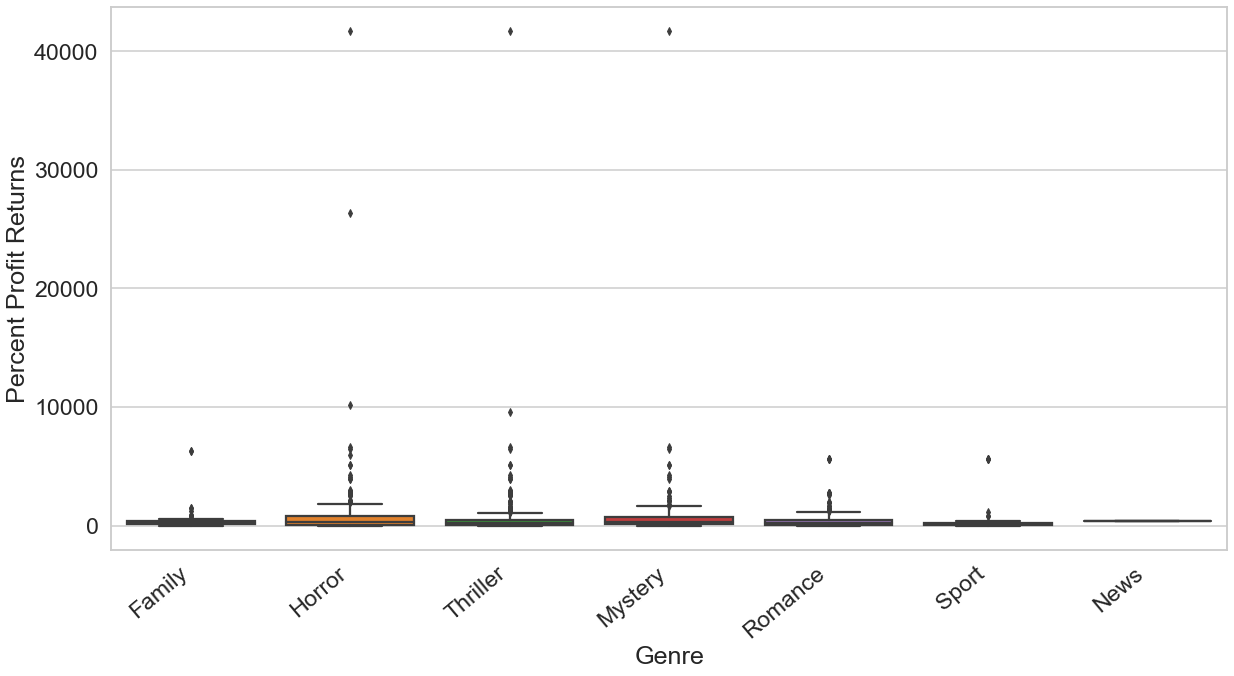

In [107]:
fig, ax = plt.subplots(figsize = (20,10))

sns.boxplot(data = df_top7_profit_returns, x = "genre", y = "percent_returns").set(ylabel = "Percent Profit Returns", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

plt.savefig('Fun_Horror_visual_we_dont_actually_need.png', dpi=300)
# Created a boxplot showing percent returns by the top seven genres

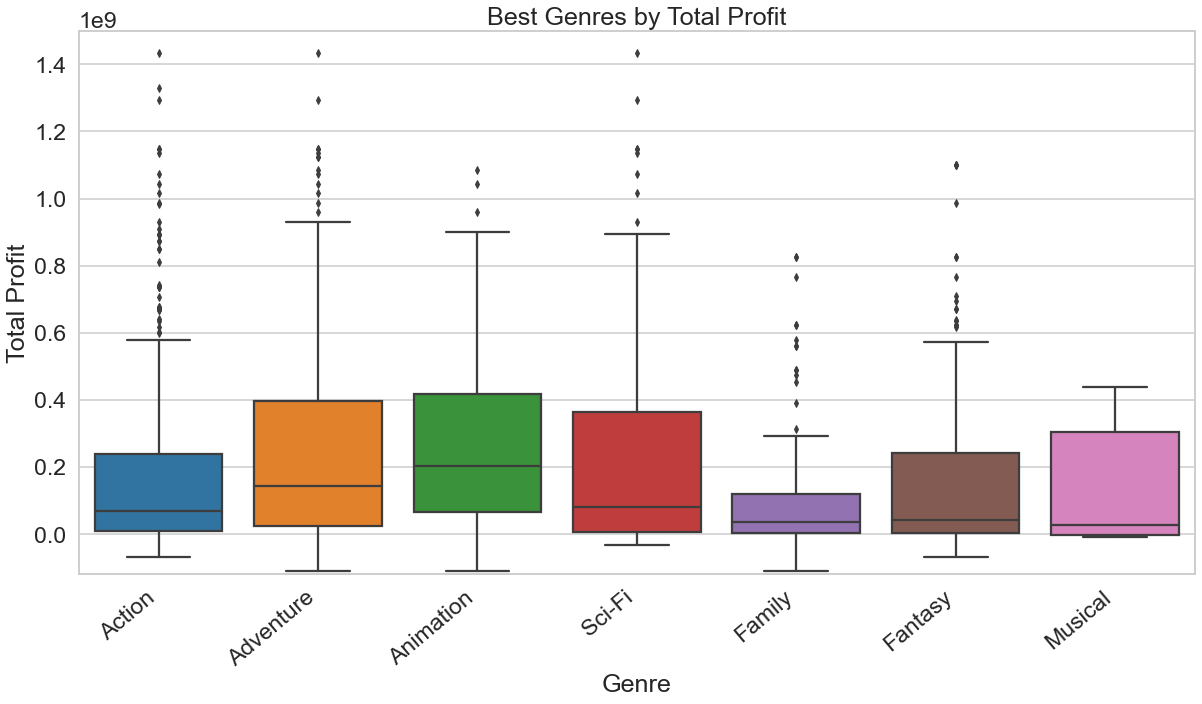

In [108]:
fig, ax = plt.subplots(figsize = (20,10))

sns.boxplot(data = df_top7_worldwide_profit, x = "genre", y = "worldwide_profit").set(ylim = (-120000000, 1500000000), ylabel = "Total Profit", xlabel = "Genre", title = "Best Genres by Total Profit")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# plt.savefig('Best_Genres_by_Total_Profit.png', dpi=300)
# Created a boxplot showing the total profit by the top seven genres in that category

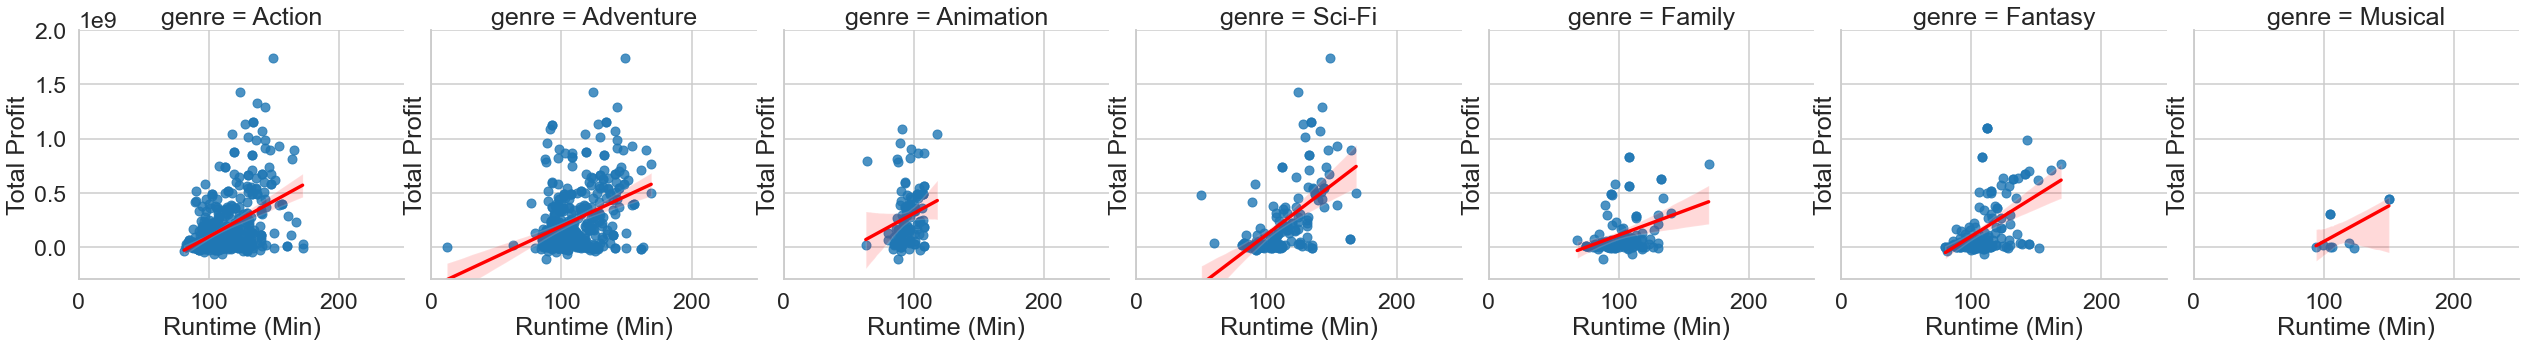

In [109]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "runtime_minutes", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-300000000, 2000000000), xlim = (0, 250), ylabel = "Total Profit", xlabel = "Runtime (Min)");

# plt.savefig('Genres_by_runtime.png', dpi=300)
# These graphs were created as linear regression models of overall profit in relation to the length of the movie.
# Each individiual genre has its own linear regression model created for it.

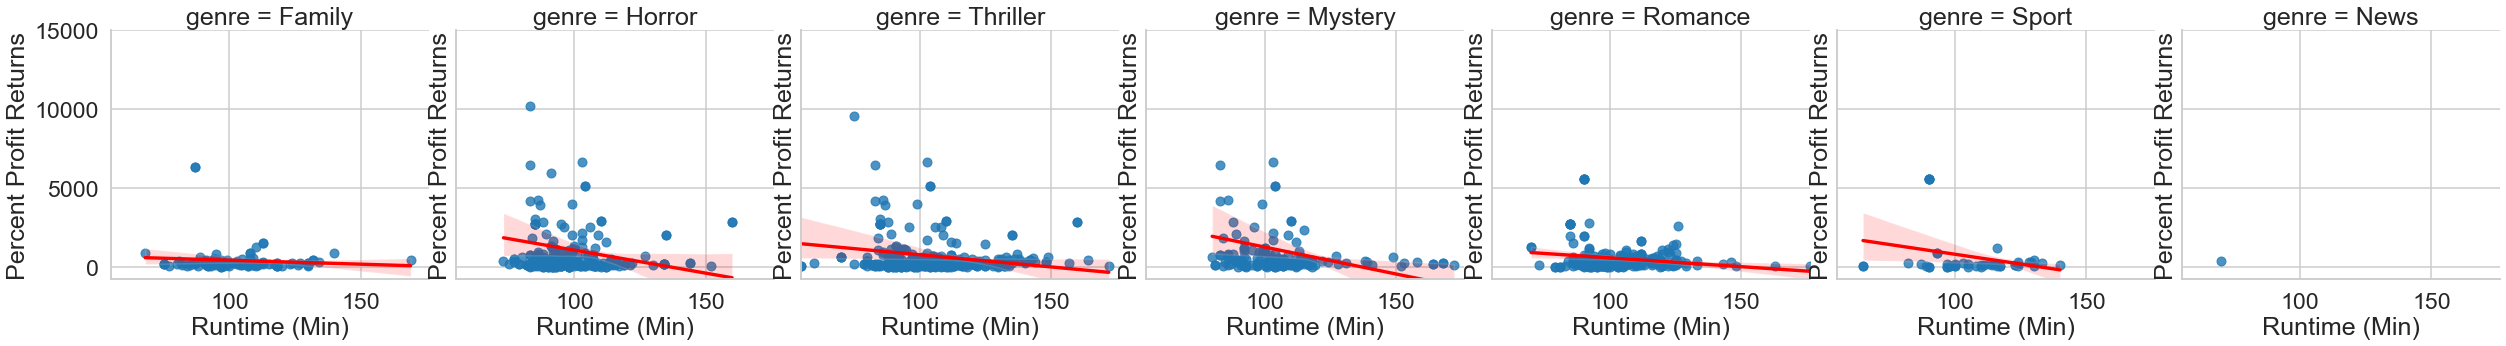

In [110]:
runtime = sns.lmplot(data = df_top7_profit_returns, x = "runtime_minutes", y = "percent_returns", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-800, 15000), ylabel = "Percent Profit Returns", xlabel = "Runtime (Min)");
# These graphs were created as linear regression models of percent returns in relation to the length of the movie.
# Each individiual genre has its own linear regression model created for it.

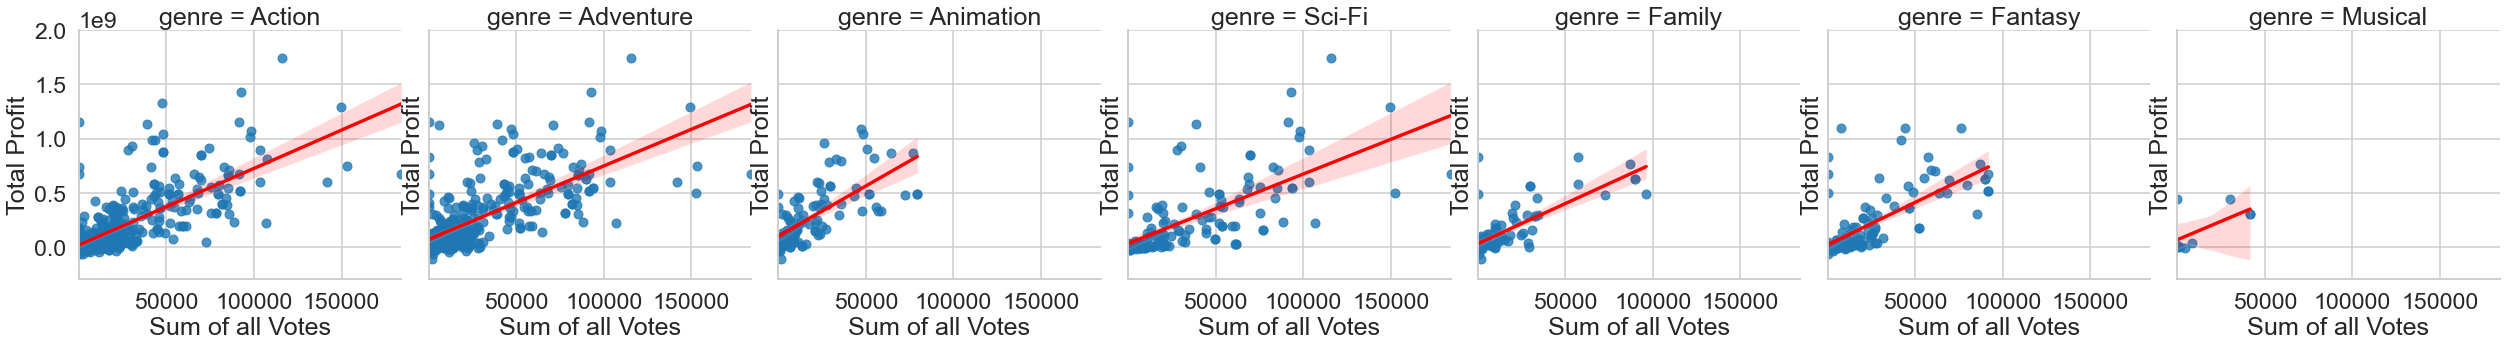

In [111]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "vote_total", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-300000000, 2000000000), ylabel = "Total Profit", xlabel = "Sum of all Votes");
# These graphs were created as linear regression models of overall profit in relation to the total numbers of upvotes the movie was given.
# Each individiual genre has its own linear regression model created for it.

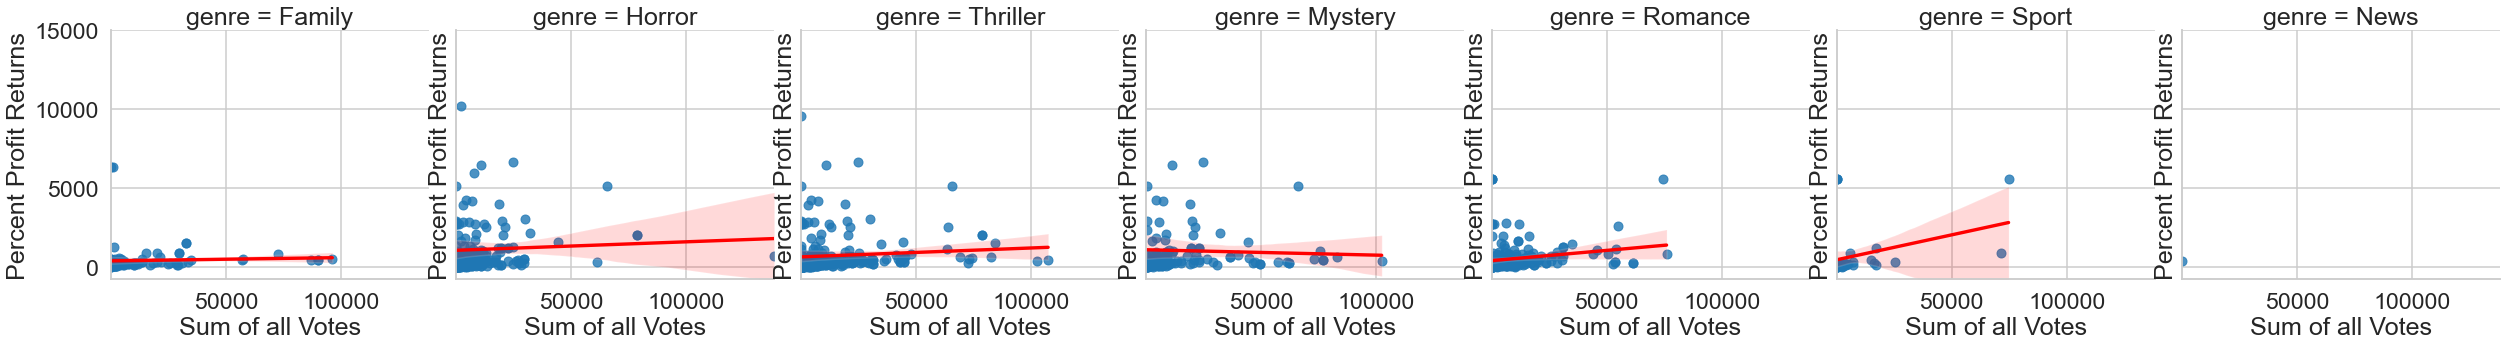

In [112]:
runtime = sns.lmplot(data = df_top7_profit_returns, x = "vote_total", y = "percent_returns", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-800, 15000), ylabel = "Percent Profit Returns", xlabel = "Sum of all Votes");
# These graphs were created as linear regression models of percent returns in relation to the total number of upvotes the movie was given.
# Each individiual genre has its own linear regression model created for it.

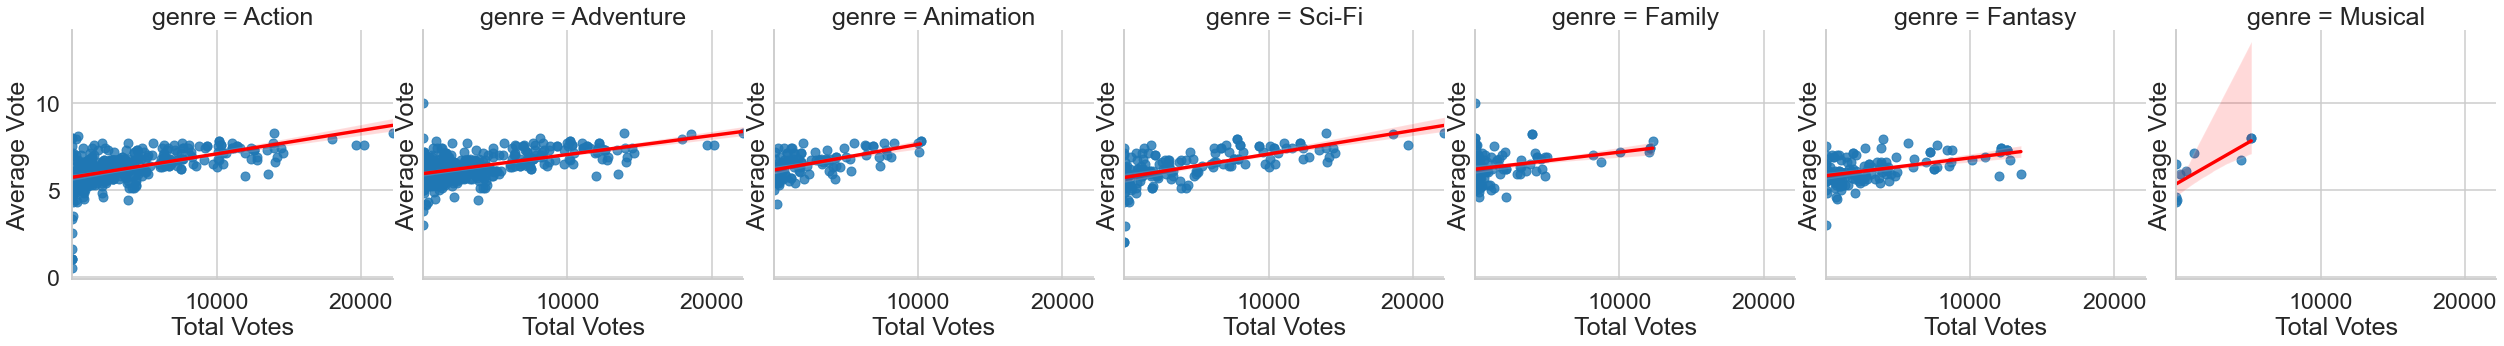

In [113]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "vote_count", y = "vote_average", col = "genre", line_kws={'color': 'red'})
runtime.set(ylabel = "Average Vote", xlabel = "Total Votes");

# plt.savefig('Genres_by_voting_nonsense.png', dpi=300)
# These graphs were created as linear regression models of the average vote in relation to the total numbers of votes the movie was given.
# Each individiual genre has its own linear regression model created for it.

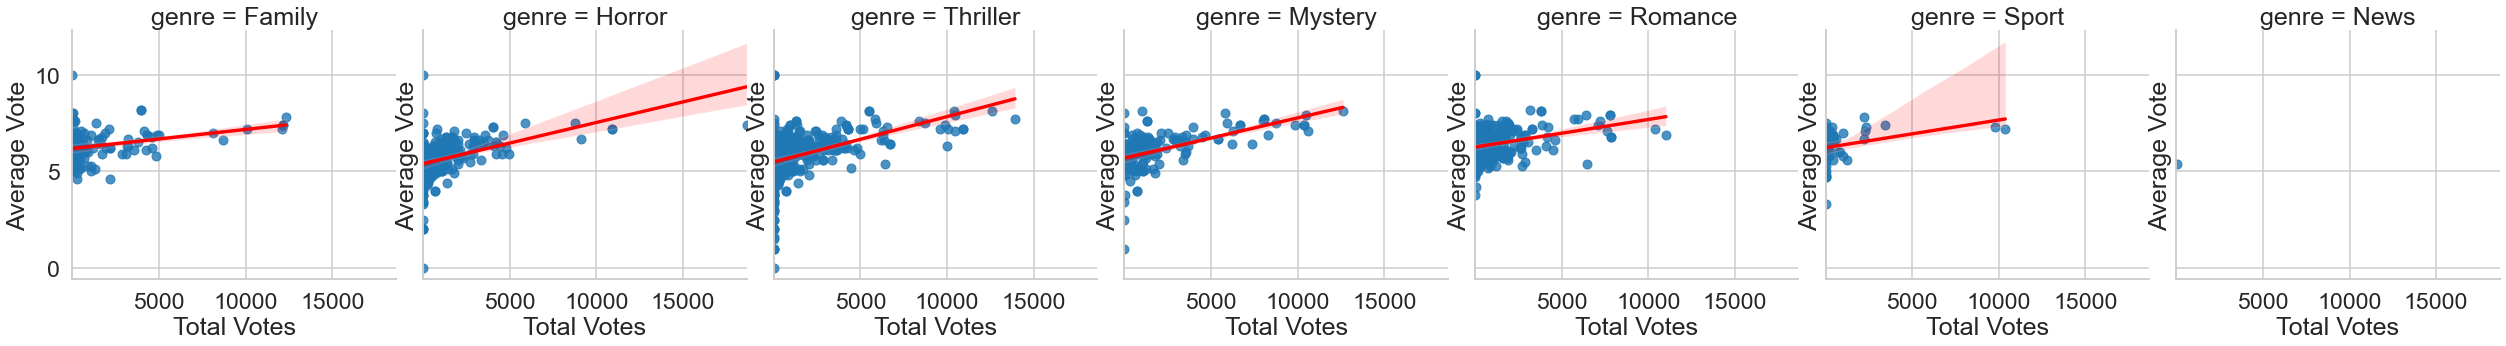

In [114]:
runtime = sns.lmplot(data = df_top7_profit_returns, x = "vote_count", y = "vote_average", col = "genre", line_kws={'color': 'red'})
runtime.set(ylabel = "Average Vote", xlabel = "Total Votes");
# These graphs were created as linear regression models of the average vote in relation to the total numbers of votes the movie was given.
# Each individiual genre has its own linear regression model created for it.

In [115]:
pd.read_sql("""
SELECT *
FROM main_table
WHERE genre = 'Musical'
ORDER BY percent_returns DESC
""", conn)

,index,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns
0,1685,0.955,Cinderella,4.6,8,36.8,150.0,Musical,95000000,534551353,439551353,2012-06-06,562.685635
1,1686,29.056,Cinderella,6.7,4517,30263.9,150.0,Musical,95000000,534551353,439551353,2015-03-13,562.685635
2,3964,22.009,The Greatest Showman,8.0,5197,41576.0,105.0,Musical,84000000,386665550,302665550,2017-12-20,460.316131
3,3967,22.009,The Greatest Showman,8.0,5197,41576.0,105.0,Musical,84000000,386665550,302665550,2017-12-20,460.316131
4,4277,2.733,The Covenant,4.4,14,61.6,99.0,Musical,20000000,38164784,18164784,2017-02-07,190.823920
5,339,8.676,Burlesque,7.1,1195,8484.5,119.0,Musical,55000000,90552675,35552675,2010-11-23,164.641227
6,1432,11.369,Rock of Ages,6.1,686,4184.6,123.0,Musical,70000000,61031932,-8968068,2012-06-15,87.188474
7,3270,5.079,The Last Five Years,5.9,230,1357.0,94.0,Musical,2000000,205298,-1794702,2015-02-13,10.264900
8,515,1.224,Standing Ovation,4.3,12,51.6,105.0,Musical,5600000,531806,-5068194,2010-07-16,9.496536
9,2161,2.971,The Ghastly Love of Johnny X,6.5,9,58.5,106.0,Musical,2000000,2436,-1997564,2013-04-26,0.121800


In [116]:
df_main.groupby("genre").median().sort_values("worldwide_profit", ascending = False)
# median values

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
genre,,,,,,,,,
Animation,14.9535,6.60,1780.5,11367.65,95.0,87500000.0,327829122.5,202467009.0,299.854564
Adventure,15.9740,6.30,2494.0,15623.30,107.0,99000000.0,252276928.0,141751370.0,278.548520
Sci-Fi,14.6880,6.40,2898.0,18207.00,110.5,60500000.0,157526241.0,81982857.0,271.315763
Action,14.8850,6.20,2182.0,13143.20,110.0,60000000.0,135965960.0,69694743.0,239.910873
Fantasy,13.4670,6.00,1884.0,11115.60,109.0,50000000.0,91678442.0,41647574.0,222.991235
Family,10.2080,6.30,492.0,3393.80,102.0,35000000.0,76954311.0,37293371.0,213.142587
Mystery,10.8410,6.20,1098.0,6623.60,104.0,12500000.0,54104225.0,35308153.0,318.109630
News,4.7380,5.40,21.0,113.40,70.0,12000000.0,46730578.0,34730578.0,389.421483
Comedy,10.2850,6.20,814.5,4906.80,101.0,24000000.0,60376812.5,29817257.5,244.057020


In [117]:
df_main.groupby("genre").std().sort_values("worldwide_profit", ascending = False)
# standard deviation values

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
genre,,,,,,,,,
Sci-Fi,12.356796,1.013955,4675.933535,35432.670882,20.601215,7.928861e+07,3.979697e+08,3.368228e+08,324.133479
Adventure,10.314864,0.817292,4114.982190,30733.315553,19.561859,7.387076e+07,3.509658e+08,3.018691e+08,265.200600
Fantasy,10.091369,0.750039,3454.311977,24041.662434,17.281058,8.006270e+07,3.276507e+08,2.693866e+08,417.901237
Action,10.259079,0.963254,3733.533048,27529.579582,17.909608,7.027044e+07,3.172053e+08,2.666629e+08,353.909497
Animation,6.715705,0.702801,2669.633669,19818.380073,8.579568,5.522789e+07,2.950703e+08,2.643117e+08,294.826046
Sport,6.884921,0.902238,2119.846063,15397.831949,17.158046,3.344526e+07,2.639669e+08,2.382381e+08,1557.455911
Family,8.677706,0.888508,2837.104754,20602.355782,16.309967,6.225794e+07,2.438258e+08,1.990399e+08,873.410407
Musical,10.202152,1.379372,2291.323987,17747.977914,20.012218,3.979180e+07,2.286713e+08,1.944202e+08,235.478836
Horror,6.011405,1.080712,2061.179607,14651.409073,14.881914,3.822154e+07,2.079199e+08,1.786043e+08,3500.779366


In [118]:
df_main.groupby("genre").mean().sort_values("worldwide_profit", ascending = False)

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
genre,,,,,,,,,
Animation,15.311292,6.554717,2785.566038,19298.707547,95.169811,9.959434e+07,3.774225e+08,2.778281e+08,383.583839
Adventure,17.680828,6.374536,3976.984085,27198.927851,111.339523,1.052349e+08,3.592523e+08,2.540174e+08,334.731109
Sci-Fi,17.331122,6.331410,4589.583333,32000.405769,113.596154,8.645247e+07,3.223228e+08,2.358703e+08,367.619218
Action,16.688753,6.187773,3410.635371,22976.101528,112.849345,8.257904e+07,2.615523e+08,1.789733e+08,322.571959
Fantasy,15.602755,6.130216,3082.676259,20112.976978,110.410072,8.232482e+07,2.582219e+08,1.758970e+08,339.335712
Musical,10.608100,6.160000,1706.500000,12765.050000,115.600000,5.126000e+07,2.032923e+08,1.520323e+08,250.854039
Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206
Comedy,11.379656,6.270415,1633.726644,10978.081315,101.719723,3.883083e+07,1.331579e+08,9.432706e+07,376.500128
Sport,7.775196,6.358696,925.043478,6511.928261,105.847826,2.530000e+07,1.096872e+08,8.438722e+07,644.462607
